In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm
from sklearn.impute import SimpleImputer
%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import Lasso
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re
import os

In [174]:
os.path.abspath('')

'C:\\Users\\JG\\jupyter directory\\AIM\\TERM3\\ML2\\group project\\stackoverflow_salary\\nov 30'

# Load Data

In [175]:
df_raw = pd.read_csv(r'C:\\Users\\JG\\jupyter directory\\AIM\\TERM3\\ML2\\group project\\stackoverflow_salary\\survey_results_public.csv')
df_raw

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physic...,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Neither easy nor difficult,816816.0


# Removing unwanted columns

In [176]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase']
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop.head(3)

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,"Secondary school (e.g. American high school, G...",NaN,NaN,"Developer, mobile",20 to 99 employees,C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift,PostgreSQL;SQLite,NaN,MacOS,A few times per month or weekly,25-34 years old,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,NaN,NaN,NaN,JavaScript;Python,PostgreSQL,NaN,Windows,Daily or almost daily,18-24 years old,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,NaN,NaN,NaN,Assembly;C;Python;R;Rust,SQLite,Heroku,MacOS,Multiple times per day,18-24 years old,NaN


In [177]:
df_drop.dropna(subset=['ConvertedCompYearly', 'YearsCode', 'YearsCodePro', 'Age', 'EdLevel', 'Employment', 'OrgSize', 'DevType'], inplace=True)

In [178]:
developing_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 
                        'Sri Lanka', 'Georgia', 'Turkey', 'Pakistan', 'Lebanon', 
                        'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
                        'Syrian Arab Republic', 'Viet Nam', 
                        "Lao People's Democratic Republic", 'Nepal', 'Philippines', 
                        'Azerbaijan', 'Armenia', 'Thailand', 'Myanmar', 'Kazakhstan', 
                        'Iraq', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 'Tajikistan', 
                        'Palestine', 'Afghanistan', 'Mongolia', 'Maldives','Turkmenistan']


df_drop = df_drop[df_drop['Country'].isin(developing_countries)]
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
29,30,I am a developer by profession,Employed full-time,Russian Federation,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,16,"Developer, desktop or enterprise applications;...",2 to 9 employees,Delphi;Java;SQL,PostgreSQL,NaN,Linux-based,Multiple times per day,35-44 years old,37752.0
33,34,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, game or graphics",2 to 9 employees,Assembly;C;C#;C++;HTML/CSS;Java;JavaScript;Mat...,NaN,NaN,Windows,A few times per week,18-24 years old,11832.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
102,103,I am a developer by profession,Employed full-time,Pakistan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,1,"Developer, back-end;Student",20 to 99 employees,Python,NaN,AWS,Linux-based,A few times per month or weekly,18-24 years old,7788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83399,83400,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,6,"Developer, front-end",20 to 99 employees,HTML/CSS;JavaScript;TypeScript,NaN,AWS;Microsoft Azure,MacOS,A few times per week,25-34 years old,27923.0
83407,83408,I am a developer by profession,Employed full-time,Kyrgyzstan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,3,"Developer, front-end","10,000 or more employees",HTML/CSS;JavaScript;TypeScript,NaN,NaN,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,20616.0
83411,83412,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,5,"Developer, back-end",100 to 499 employees,Java;JavaScript;SQL,MySQL,AWS,MacOS,Less than once per month or monthly,25-34 years old,48866.0
83422,83423,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Viet Nam,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",26,18,"Developer, full-stack","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;PHP;Ruby,MariaDB;PostgreSQL;SQLite,NaN,Linux-based,NaN,35-44 years old,20000.0


In [179]:
data_dev_list = ['Data scientist or machine learning specialist',
                 'Database administrator',
                 'Data or business analyst',
                 'Engineer, data']

ser_dev = df_drop['DevType'].str.split(';')
index_list = []
for idx, elem in ser_dev.iteritems():
    for item in elem:
        if item in data_dev_list:
            index_list.append(idx)
            break
df_devs = df_drop.loc[index_list,:]
df_devs

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
29,30,I am a developer by profession,Employed full-time,Russian Federation,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,16,"Developer, desktop or enterprise applications;...",2 to 9 employees,Delphi;Java;SQL,PostgreSQL,NaN,Linux-based,Multiple times per day,35-44 years old,37752.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2,2,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,7,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4,2,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,"I am not primarily a developer, but I write co...",Employed full-time,India,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,11,"Developer, front-end;Developer, full-stack;Dev...",20 to 99 employees,Bash/Shell;Go;HTML/CSS;PHP;SQL,Elasticsearch;MariaDB;Redis;SQLite,AWS;DigitalOcean,MacOS,Daily or almost daily,25-34 years old,13962.0
83291,83292,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,2,"Engineer, data;Data or business analyst;Engine...","10,000 or more employees",C;HTML/CSS;Java;PowerShell;Python;SQL,Microsoft SQL Server;MySQL;Oracle;SQLite,Google Cloud Platform,Windows,A few times per week,18-24 years old,5026.0
83294,83295,I am a developer by profession,Employed full-time,Russian Federation,Some college/university study without earning ...,15,13,"Developer, back-end;Database administrator;Dev...",20 to 99 employees,Node.js;PHP,MariaDB;MySQL;PostgreSQL;SQLite,Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,30192.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,5,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0


# OHE semicolon features

In [180]:
df_devs['LanguageHaveWorkedWith'] = df_devs['LanguageHaveWorkedWith'].copy().fillna('other')

In [181]:
li = []
for row in df_devs['LanguageHaveWorkedWith'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

39

In [182]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_devs[col_name].str.split(';'):
         li = li + row

    df_try = df_devs[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [183]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 39, 'Lang')
lang_OHE

,Lang_Python,Lang_SQL,Lang_JavaScript,Lang_HTML/CSS,Lang_Java,Lang_Node.js,Lang_PHP,Lang_C++,Lang_C#,Lang_Bash/Shell,...,Lang_Julia,Lang_Haskell,Lang_Clojure,Lang_COBOL,Lang_Erlang,Lang_Crystal,Lang_LISP,Lang_APL,Lang_other,Lang_F#
index,,,,,,,,,,,,,,,,,,,,,
29,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
148,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83291,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83294,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
li = []
for row in df_devs['DevType'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

25

In [185]:
Dev_OHE = OHE_semicolon_vals('DevType', 25, 'Dev')
Dev_OHE

,"Dev_Developer, back-end","Dev_Developer, full-stack",Dev_Database administrator,Dev_Data scientist or machine learning specialist,"Dev_Engineer, data","Dev_Developer, front-end",Dev_Data or business analyst,"Dev_Developer, desktop or enterprise applications",Dev_System administrator,"Dev_Developer, mobile",...,Dev_Engineering manager,"Dev_Engineer, site reliability",Dev_Academic researcher,Dev_Educator,Dev_Student,"Dev_Developer, game or graphics",Dev_Scientist,"Dev_Senior Executive (C-Suite, VP, etc.)",Dev_Other (please specify):,Dev_Marketing or sales professional
index,,,,,,,,,,,,,,,,,,,,,
29,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
168,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
83291,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
83294,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
df_devs['DatabaseHaveWorkedWith'] = df_devs['DatabaseHaveWorkedWith'].copy().fillna('other')

In [187]:
li = []
for row in df_devs['DatabaseHaveWorkedWith'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

15

In [188]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 15, 'DB')
database_OHE

,DB_MySQL,DB_PostgreSQL,DB_SQLite,DB_MongoDB,DB_Microsoft SQL Server,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
index,,,,,,,,,,,,,,,
29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
154,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0
168,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0
83291,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0
83294,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [189]:
df_devs['PlatformHaveWorkedWith'] = df_devs['PlatformHaveWorkedWith'].copy().fillna('other')

In [190]:
li = []
for row in df_devs['PlatformHaveWorkedWith'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

8

In [191]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 8, 'Plat')
platform_OHE

,Plat_AWS,Plat_Google Cloud Platform,Plat_other,Plat_Microsoft Azure,Plat_DigitalOcean,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,,
29,0,0,1,0,0,0,0,0
58,0,0,0,0,0,1,0,0
148,0,1,0,0,0,0,0,0
154,0,0,0,0,0,1,0,0
168,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
83046,1,0,0,0,1,0,0,0
83291,0,1,0,0,0,0,0,0
83294,0,1,0,0,0,0,0,0


# Normal OHE

In [192]:
df_devs.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'OpSys', 'SOPartFreq', 'Age',
       'ConvertedCompYearly'],
      dtype='object')

In [193]:
df_devs['EdLevel'].unique()

array(['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Professional degree (JD, MD, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Associate degree (A.A., A.S., etc.)', 'Primary/elementary school',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Something else'], dtype=object)

In [194]:
OHE_list = ['Employment', 'Country', 'Age', 'OpSys']
pd.get_dummies(df_devs[OHE_list])

,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",Country_Afghanistan,Country_Armenia,Country_Azerbaijan,Country_Bhutan,Country_Cambodia,Country_China,Country_Georgia,...,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,OpSys_BSD,OpSys_Linux-based,OpSys_MacOS,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL)
29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
58,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
154,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
168,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
83291,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
83294,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
83356,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [195]:
all_OHE = pd.concat([pd.get_dummies(df_devs[OHE_list]), platform_OHE, Dev_OHE, lang_OHE, database_OHE], axis=1)
all_OHE

,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",Country_Afghanistan,Country_Armenia,Country_Azerbaijan,Country_Bhutan,Country_Cambodia,Country_China,Country_Georgia,...,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
168,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
83291,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
83294,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
83356,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0


# Ordinal

In [196]:

MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_devs['MainBranch'] = df_devs['MainBranch'].copy().map(MainBranch_mapping)

In [197]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_devs['EdLevel'] = df_devs['EdLevel'].copy().map(EdLevel_mapping)


In [198]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_devs['OrgSize'] = df_devs['OrgSize'].copy().map(OrgSize_mapping)

In [199]:
SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_devs['SOPartFreq'] = df_devs['SOPartFreq'].copy().map(SOPartFreq_mapping)

In [200]:
df_devs['ConvertedCompYearly'] = df_devs['ConvertedCompYearly'].astype(int)

In [201]:
df_encoded = pd.merge(df_devs, all_OHE, left_index=True, right_index=True).drop(columns=['DevType',
                                                                            'Employment',
                                                                            'Country',
                                                                            'Age',
                                                                            'OpSys',
                                                                            'LanguageHaveWorkedWith', 
                                                                            'DatabaseHaveWorkedWith', 
                                                                            'PlatformHaveWorkedWith', 'ResponseId'], axis=0)
df_encoded.head(10)

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
29,1,6,20,16,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,8,5,3,4,1.0,22644,1,0,0,...,0,0,0,0,1,0,0,0,0,0
148,0,6,2,2,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
154,1,5,20,7,1,4.0,2340,0,0,1,...,1,1,1,0,0,0,0,0,0,0
168,1,3,4,2,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,0,0,0,0
213,1,7,15,9,9,2.0,75492,1,0,0,...,0,0,0,0,0,0,0,0,0,0
378,1,5,12,5,2,0.0,217800,1,0,0,...,0,0,0,1,1,0,0,0,0,0
412,1,3,7,3,1,5.0,72000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
554,1,5,3,1,1,3.0,11724,0,0,1,...,0,0,0,0,0,0,0,0,0,0
571,1,5,10,8,3,3.0,29320,1,0,0,...,1,0,0,1,1,1,0,0,0,0


In [202]:
def years_code_mapping(x):
    if x == 'Less than 1 year':
        return 0.5
    elif x == 'More than 50 years':
        return 55
    else:
        return int(x)

df_encoded['YearsCode'] = df_encoded['YearsCode'].copy().apply(years_code_mapping)
#YearsCodePro
df_encoded['YearsCodePro'] = df_encoded['YearsCodePro'].copy().apply(years_code_mapping)


# Removing Outliers

In [203]:
from sklearn.ensemble import IsolationForest
isoforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.12 , max_features=1, random_state=11)
isoforest.fit(df_encoded[['ConvertedCompYearly']])

df_encoded['scores']=isoforest.decision_function(df_encoded[['ConvertedCompYearly']])
df_encoded['anomaly']=isoforest.predict(df_encoded[['ConvertedCompYearly']])

X does not have valid feature names, but IsolationForest was fitted with feature names


In [204]:
outliers_iso = df_encoded[df_encoded['anomaly']==-1].index
print('number of outliers: ', len(outliers_iso), '\n shape of df_final with outliers: ', df_encoded.shape)
df_encoded.drop(outliers_iso, axis=0, inplace=True)

number of outliers:  148 
 shape of df_final with outliers:  (1247, 143)


In [205]:
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,scores,anomaly
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,0,0,0.065146,1
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,1,0,0,0,0,0,0.093599,1
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,0,0,0.063527,1
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,1,0,0,0,0,0,0,0,0.035999,1
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,0,0,0.084331,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,1,0,0,0,0,0,0,0.095315,1
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,1,0,0,0,0,0,0.099633,1
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,0,0,0,0.064865,1
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,1,0,0,0,0,0,0,0,0.106633,1


# Adding Counts

In [206]:
def filter_lang(prefix):
    li = []
    for elem in df_encoded.columns:
        if prefix in elem:
            li.append(elem)
    return li

lang_cols = filter_lang('Lang_')
df_encoded['LCount'] = df_encoded[lang_cols].sum(axis=1)

dev_cols = filter_lang('Dev_')
df_encoded['DCount'] = df_encoded[dev_cols].sum(axis=1)

plat_cols = filter_lang('Plat_')
df_encoded['PCount'] = df_encoded[plat_cols].sum(axis=1)

db_cols = filter_lang('DB_')
df_encoded['DbCount'] = df_encoded[db_cols].sum(axis=1)


In [207]:
df_encoded.drop(columns=['scores', 'anomaly'], inplace=True)

In [208]:
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,3,4,1,1
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,1,0,0,0,0,0,5,2,1,1
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,1,2,1,1
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,0,7,8,1,5
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,4,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,0,5,7,2,4
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,1,0,0,0,0,0,6,3,1,4
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,0,2,4,1,4
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,0,18,16,6,7


# Adding back Country

In [209]:
df_encoded = pd.merge(df_encoded, df_devs['Country'], how='left', right_index=True, left_index=True)
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,3,4,1,1,Russian Federation
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,0,0,0,5,2,1,1,Russian Federation
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,1,2,1,1,Sri Lanka
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,4,4,2,1,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,0,0,0,6,3,1,4,India
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,2,4,1,4,Russian Federation
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,18,16,6,7,Indonesia


# Dropping countries that have < 5 rows

In [210]:
drop_list = []
for country in df_encoded['Country'].unique():
    df = df_encoded[df_encoded['Country']==country]
    if len(df) < 5:
        for elem in df.index:
            drop_list.append(elem)
len(drop_list)

22

In [211]:
df_encoded.drop(drop_list, inplace=True)
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,3,4,1,1,Russian Federation
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,0,0,0,5,2,1,1,Russian Federation
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,1,2,1,1,Sri Lanka
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,4,4,2,1,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,0,0,0,6,3,1,4,India
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,2,4,1,4,Russian Federation
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,18,16,6,7,Indonesia


# Adding GDPpC

In [212]:
def gdp_mapping(x):
    if x == 'Russian Federation':
        return 11428
    elif x == 'India':
        return 2338
    elif x == 'Indonesia':
        return 4374
    elif x == 'Iran':
        return 5830
    elif x == 'Sri Lanka':
        return 4184
    elif x == 'Georgia':
        return 4746
    elif x == 'Turkey':
        return 9519
    elif x == 'Pakistan':
        return 1254
    elif x == 'Lebanon':
        return 8955
    elif x == 'Malaysia':
        return 12265
    elif x == 'China':
        return 10710
    elif x == 'Jordan':
        return 4374
    elif x == 'Uzbekistan':
        return 1635
    elif x == 'Syrian Arab Republic':
        return 1213
    elif x == 'Viet Nam':
        return 2876
    elif x == "Lao People's Democratic Republic":
        return 2983
    elif x == 'Nepal':
        return 1113
    elif x == 'Philippines':
        return 3503
    elif x == 'Azerbaijan':
        return 4639
    elif x == 'Armenia':
        return 4627
    elif x == 'Thailand':
        return 7826
    elif x == 'Myanmar':
        return 1303
    elif x == 'Kazakhstan':
        return 9335
    elif x == 'Iraq':
        return 5997
    elif x == 'Kyrgyzstan':
        return 1325
    elif x == 'Bhutan':
        return 3768
    elif x == 'Tajikistan':
        return 804
    elif x == 'Palestine':
        return 2565
    elif x == 'Afghanistan':
        return 519
    elif x == 'Mongolia':
        return 4493
    elif x == 'Maldives':
        return 11429
    elif x == 'Turkmenistan':
        return 9327
    elif x == 'Cambodia':
        return 1730
    
    
    
df_encoded['GDPpC'] = df_encoded['Country'].copy().apply(gdp_mapping)

# ML

In [213]:
X = df_encoded[df_encoded.columns.difference(['ConvertedCompYearly'])]
y = df_encoded['ConvertedCompYearly']

## Splitting

In [214]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, stratify=X['Country'])

In [215]:
X.isna().sum() > 1

Age_18-24 years old                 False
Age_25-34 years old                 False
Age_35-44 years old                 False
Age_45-54 years old                 False
Age_55-64 years old                 False
                                    ...  
Plat_Oracle Cloud Infrastructure    False
Plat_other                          False
SOPartFreq                           True
YearsCode                           False
YearsCodePro                        False
Length: 146, dtype: bool

In [216]:
# def tune_XGBoost(X, y):
#     # from optuna.samplers import RandomSampler
#     from sklearn.model_selection import cross_validate
    
#     def optimize(trial):
#         dmatrix = xgb.DMatrix(data=X, label=y)
        
#         # Definition of space search
#         param = {
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0, step=0.1),
#         'subsample': trial.suggest_float('subsample', 0.3, 1.0, step=0.1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=10),
#         'max_depth': trial.suggest_int('max_depth', 2,15),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#         }

#         # Classifier definition
#         xgbr = xgb.XGBRegressor(seed=20, **param)

#         scaler = MinMaxScaler()
        
#         xgb_pipe = Pipeline(steps = [['scale', scaler],['xgb', xgbr]])
#         #gbm_pipe = Pipeline(steps = [['gbm', model]])
        
#         cr_val = cross_val_score(xgb_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
#         # cr_val = cross_val_score(model, X, y, cv=5, scoring='r2')
#         return np.mean(cr_val)
    
#     study = optuna.create_study(direction='minimize')
#     study.optimize(optimize, n_trials=50, n_jobs=4)
#     return study, optimize

In [253]:
def tune_XGBoost(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 2,15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        # Classifier definition
        model = xgb.XGBRegressor(seed=20, **param)

        scaler = MinMaxScaler()
        
        pipe = Pipeline(steps = [['scale', scaler],['xgb', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']

            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem


            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=500, n_jobs=4)
    return study, optimize

In [254]:
xgb_study, xgb_optimize = tune_XGBoost(X_trainval, y_trainval)

[I 2021-11-30 15:39:54,710] A new study created in memory with name: no-name-2ed8f795-855a-4129-be0b-a64e4ecc0543
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-11-30 15:40:00,818] Trial 0 finished with value: 8296.135172391125 and parameters: {'lambda': 1.64198713129333, 'alpha': 0.061274285812241695, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.22978142689969142, 'n_estimators': 240, 'max_depth': 6, 'min_child_weight': 122}. Best is trial 0 with value: 8296.135172391125.
[I 2021-11-30 15:40:02,310] Trial 2 finished with value: 8622.234701684305 and parameters: {'lambda': 0.003053472744064691, 'alpha': 0.09432483107152573, 'colsample_bytree': 0.6000000000000001, 'subsample': 1.0, 'learning_rate': 0.7646358603315953, 'n_estimators': 380, 'max_depth': 11, 'min_child_weight': 187}. Best is trial 0 with value: 8296.135172391125.
[I 2021-11-30 15:40:04,559] Trial 3 f

In [255]:
xgb_study.best_value

7937.82637612375

In [256]:
xgb_study.best_params

{'lambda': 0.01810758504378264,
 'alpha': 0.8321716401222017,
 'colsample_bytree': 0.3,
 'subsample': 0.8,
 'learning_rate': 0.05016408184186968,
 'n_estimators': 360,
 'max_depth': 9,
 'min_child_weight': 9}

In [257]:
def testing_optimal_model(model, n_trials):

    mae_list=[]
    mape_list=[]
    rmse_list=[]
    r2_list=[]
    for n in tqdm_notebook(range(n_trials)):
        (X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                              random_state=n, 
                                                              test_size=0.25, stratify=X['Country'])

        ### Fitting scalers per country
        def get_country_index(X, country):
            return X[X[f'Country_{country}']==1].index

        country_list = X['Country'].unique().tolist()
        country_index_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
            country_index_dict[c] = [get_country_index(X_train, c), scaler]

        #### scaling train sets
        # y
        ytrain_scaled_dict = {}
        for key, val in country_index_dict.items():
            y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
            ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

        y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

        # X 
        X_train_final = X_train.drop(columns=['Country'], axis=0)

        y_train_final.name = 'y'
        y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


        #### scaling val sets
        # y

        country_index_val_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
            country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


        yval_scaled_dict = {}
        for key, val in country_index_val_dict.items():
            y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
            yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

        y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

        # X
        X_val_final = X_val.drop(columns=['Country'], axis=0)


        y_val_final.name = 'y'
        y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



        scaler = MinMaxScaler()
        X_train_feed = scaler.fit_transform(X_train_final)
        X_val_feed = scaler.transform(X_val_final)

        model.fit(X_train_feed, y_train_final)

        y_pred = model.predict(X_val_feed)

    #     ### Inverse scaling before calculating MAE
        y_pred_dict = {}
        for key, val in country_index_val_dict.items():
            val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
            y_country = y_pred[val_indices]
            # inverse minmax scaling....
            y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
            y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


        y_val_dict = {}
        for key, val in y_pred_dict.items():
            y_val_country = y_val_final.reset_index(drop=True)[val[0]]
            y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
            y_val_dict[key] = y_val_country_inversed_scaled.ravel()

        y_val_sorted = [list(elem) for elem in y_val_dict.values()]
        y_val_mae = []
        for elem in y_val_sorted:
            y_val_mae = y_val_mae + elem

        y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
        y_pred_mae = []
        for elem in y_pred_sorted:
            y_pred_mae = y_pred_mae + elem


        mae = mean_absolute_error(y_val_mae, y_pred_mae)
        r2 = r2_score(y_val_mae, y_pred_mae)
        mape = mean_absolute_percentage_error(y_val_mae, y_pred_mae)
        rmse = np.sqrt(mean_squared_error(y_val_mae, y_pred_mae))
        
        mae_list.append(mae)
        mape_list.append(mape)
        rmse_list.append(rmse)
        r2_list.append(r2)
    return np.mean(mae_list), np.mean(mape_list), np.mean(rmse_list), np.mean(r2_list), mae_list

In [266]:
# {'lambda': 2.6023460786610775,
#  'alpha': 0.031034911484978875,
#  'colsample_bytree': 0.9000000000000001,
#  'subsample': 0.5,
#  'learning_rate': 0.035172129329832345,
#  'n_estimators': 350,
#  'max_depth': 2,
#  'min_child_weight': 11}

# xgbr = xgb.XGBRegressor(seed=20, **xgb_study.best_params)
xgbr = xgb.XGBRegressor(seed=20, **{'lambda': 2.6023460786610775,
                                  'alpha': 0.031034911484978875,
                                  'colsample_bytree': 0.9000000000000001,
                                  'subsample': 0.5,
                                  'learning_rate': 0.035172129329832345,
                                  'n_estimators': 350,
                                  'max_depth': 2,
                                  'min_child_weight': 11})
mae, mape, rmse, r2, mae_list = testing_optimal_model(xgbr, 50)
mae

  0%|          | 0/50 [00:00<?, ?it/s]

8221.788261583117

In [259]:
display(np.argmin(mae_list))
mae_list[np.argmin(mae_list)]

7

7744.426664677373

In [260]:
(X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                      random_state=7, 
                                                      test_size=0.25, stratify=X['Country'])

### Fitting scalers per country
def get_country_index(X, country):
    return X[X[f'Country_{country}']==1].index

country_list = X['Country'].unique().tolist()
country_index_dict = {}
for c in country_list:
    scaler = MinMaxScaler()
    scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
    country_index_dict[c] = [get_country_index(X_train, c), scaler]

#### scaling train sets
# y
ytrain_scaled_dict = {}
for key, val in country_index_dict.items():
    y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
    ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

# X 
X_train_final = X_train.drop(columns=['Country'], axis=0)

y_train_final.name = 'y'
y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


#### scaling val sets
# y

country_index_val_dict = {}
for c in country_list:
    scaler = MinMaxScaler()
    scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
    country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


yval_scaled_dict = {}
for key, val in country_index_val_dict.items():
    y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
    yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

# X
X_val_final = X_val.drop(columns=['Country'], axis=0)


y_val_final.name = 'y'
y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



scaler = MinMaxScaler()
X_train_feed = scaler.fit_transform(X_train_final)
X_val_feed = scaler.transform(X_val_final)

xgbr = xgbr.fit(X_train_feed, y_train_final)

y_pred = xgbr.predict(X_val_feed)

#     ### Inverse scaling before calculating MAE
y_pred_dict = {}
for key, val in country_index_val_dict.items():
    val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
    y_country = y_pred[val_indices]
    # inverse minmax scaling....
    y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
    y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


y_val_dict = {}
for key, val in y_pred_dict.items():
    y_val_country = y_val_final.reset_index(drop=True)[val[0]]
    y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
    y_val_dict[key] = y_val_country_inversed_scaled.ravel()

y_val_sorted = [list(elem) for elem in y_val_dict.values()]
y_val_mae = []
for elem in y_val_sorted:
    y_val_mae = y_val_mae + elem

y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
y_pred_mae = []
for elem in y_pred_sorted:
    y_pred_mae = y_pred_mae + elem


mae = mean_absolute_error(y_val_mae, y_pred_mae)

In [280]:
explainer_xgb = shap.TreeExplainer(xgbr)
shap_values = explainer_xgb.shap_values(X_val_feed)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


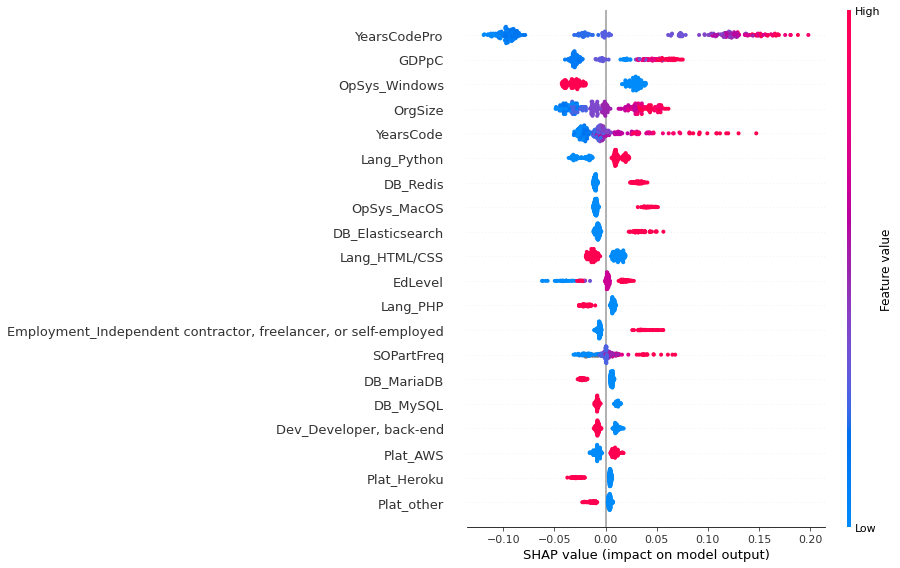

In [283]:
fig, ax = plt.subplots(figsize=(10,15))
shap.summary_plot(shap_values = shap_values, features = X_val_feed, feature_names= X_val_final.columns)

In [287]:
shap.summary_plot?

Signature:
shap.summary_plot(
    shap_values,
    features=None,
    feature_names=None,
    max_display=None,
    plot_type=None,
    color=None,
    axis_color='#333333',
    title=None,
    alpha=1,
    show=True,
    sort=True,
    color_bar=True,
    plot_size='auto',
    layered_violin_max_num_bins=20,
    class_names=None,
    class_inds=None,
    color_bar_label='Feature value',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x000002272AF58EE0>,
    auto_size_plot=None,
    use_log_scale=False,
)
Docstring:
Create a SHAP beeswarm plot, colored by feature values when they are provided.

Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.

features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x # features) or a feature_names list as shorthand

feature_names : 

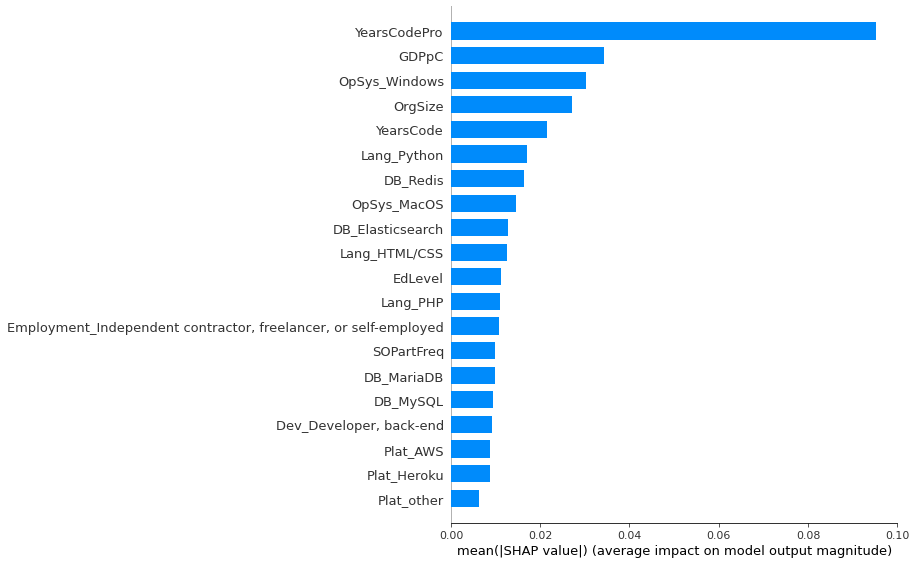

In [286]:
shap.summary_plot(shap_values=shap_values, 
                  features=X_val_feed,
                  feature_names= X_val_final.columns,
                  plot_type="bar")

In [289]:
df_encoded[df_encoded['Country']=='Philippines'][['Country', 'ConvertedCompYearly']].describe()

,ConvertedCompYearly
count,29.000000
mean,17177.931034
std,15595.990224
min,2844.000000
25%,5688.000000
50%,11856.000000
75%,23700.000000
max,59381.000000


In [245]:
# model_xgbr = xgbr.fit(X_trainval.drop(columns='Country'), y_trainval)
# y_pred = xgbr.predict(X_holdout.drop(columns='Country'))

# fig, ax = plt.subplots(figsize=(15,10))

# plt.scatter(y_holdout, y_pred)
# ax.axline([0, 0], [y_holdout.max(), y_holdout.max()], color='red')
# # plt.scatter(range(len(y_pred)), y_pred, label='preds')
# # plt.legend()
# plt.show()

In [246]:
# xgb_results = pd.DataFrame({'actual': y_holdout,
#                             'pred': y_pred})

# print(xgb_results['actual'].quantile(0.25))
# print(xgb_results['actual'].quantile(0.50))
# print(xgb_results['actual'].quantile(0.75), '\n')

# q1 = xgb_results[xgb_results['actual'] <= xgb_results['actual'].quantile(0.25)]
# q2 = xgb_results[(xgb_results['actual'] > xgb_results['actual'].quantile(0.25)) & 
#                  (xgb_results['actual'] <= xgb_results['actual'].quantile(0.55))]
# q3 = xgb_results[(xgb_results['actual'] > xgb_results['actual'].quantile(0.55)) &
#                  (xgb_results['actual'] <= xgb_results['actual'].quantile(0.75))]
# q4 = xgb_results[xgb_results['actual'] > xgb_results['actual'].quantile(0.75)]

# q1['quantile'] = 1
# q2['quantile'] = 2
# q3['quantile'] = 3
# q4['quantile'] = 4

# q1['MAE'] = abs(q1['actual'] - q1['pred'])
# q2['MAE'] = abs(q2['actual'] - q2['pred'])
# q3['MAE'] = abs(q3['actual'] - q3['pred'])
# q4['MAE'] = abs(q4['actual'] - q4['pred'])

# print(q1.shape)
# print(q2.shape)
# print(q3.shape)
# print(q4.shape, '\n')

# print(mean_absolute_error(q1['actual'], q1['pred']))
# print(mean_absolute_error(q2['actual'], q2['pred']))
# print(mean_absolute_error(q3['actual'], q3['pred']))
# print(mean_absolute_error(q4['actual'], q4['pred']))

In [247]:
# df_quantiles = pd.concat([q1,q2,q3,q4])

# no_4 = df_quantiles[df_quantiles['quantile'] != 4]
# mean_absolute_error(no_4['actual'], no_4['pred'])

In [248]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_percentage_error(y_holdout, y_pred))
print(np.sqrt(mean_squared_error(y_holdout, y_pred)))
print(mean_absolute_error(y_holdout, y_pred))
print(r2_score(y_holdout, y_pred))

0.9999712335356759
25295.832591975148
20310.802784590865
-1.8145046250017662


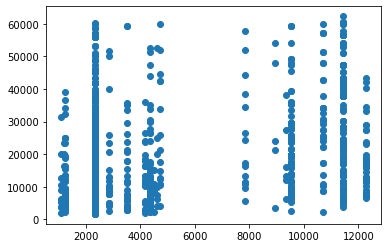

In [269]:
plt.scatter(df_encoded['GDPpC'], df_encoded['ConvertedCompYearly'])